In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (12, 7)
sns.set()

In [2]:
def get_comparison_df(id):
    comparison_id = id 
    results_path = '../results/comparisons/grid_comparison_{}_scores.csv'.format(comparison_id)

    # Dataframe containing comparisons results between different architectures
    df = pd.read_csv(results_path)
    initial_df = df
    
    # ---------------------
    # We format the results df to see clearly the hyperparameters
    # convert the config params dict in the df to python dicts
    n = df.shape[0]
    config_params = []
    for i in range(n):
        config_params.append(ast.literal_eval(df.loc[i, 'config_params']))

    # we assume that config params are the same for all runs
    for key in config_params[0].keys():
        params = [config_params[i][key] for i in range(n)]
        df[key] = params

    # df with the confusion matrix and other
    full_df = df

    # keep most important infos
    df = df.drop(['Unnamed: 0', 'cm', 'config_params', 'max_epochs', 'module__temporal_attention'],
                 axis=1)
    
    # ---------------------
    # Convert the list of nb of layers (module__channel_list e.g.) to readable columns
    for i in range(n):
        c_list = df.loc[i, 'module__channel_list']
        h_layers = df.loc[i, 'module__fc_hidden_layers']

        for j, c in enumerate(c_list):
            df.loc[i, 'layer_{}_channels'.format(j)] = int(c[0])
            df.loc[i, 'layer_{}_groups'.format(j)] = int(c[1])
        df.loc[i, 'nb_layers'] = len(c_list) # assuming there is no preprocessing

        df.loc[i, 'fc_layer_0'] = h_layers[0]
        df.loc[i, 'fc_layer_1'] = h_layers[1]

    # convert channel list to a string (for category dtype)
    df['module__channel_list'] = df['module__channel_list'].apply(lambda x: x.__str__()).astype('category')
    return df

In [21]:
def get_grid_search_df(id):
    comparison_id = id 
    results_path = '../results/grid_search_{}/detailed.csv'.format(comparison_id)

    # Dataframe containing comparisons results between different architectures
    df = pd.read_csv(results_path)
    initial_df = df

    # convert the string objects df to python lists
    df.param_module__channel_list = df.param_module__channel_list.apply(ast.literal_eval)
    df.param_module__fc_hidden_layers = df.param_module__fc_hidden_layers.apply(ast.literal_eval)

    n = df.shape[0]
    
    # Convert the list of nb of layers (module__channel_list e.g.) to readable columns
    for i in range(n):
        c_list = df.loc[i, 'param_module__channel_list']
        h_layers = df.loc[i, 'param_module__fc_hidden_layers']
        
        # eventual preprocessing layers
        if c_list[0][1] == None:
            df.loc[i, 'layer_preprocessing_channels'] = int(c_list[0][0])
            c_list = c_list[1:]

        # convolution layers
        for j, c in enumerate(c_list):
            df.loc[i, 'layer_{}_channels'.format(j)] = int(c[0])
            df.loc[i, 'layer_{}_groups'.format(j)] = int(c[1])
        
        df.loc[i, 'nb_layers'] = len(c_list)
        df.loc[i, 'nb_h_layers'] = len(h_layers)

        # fc layers
        for j in range(len(h_layers)):
            df.loc[i, 'fc_layer_{}'.format(j)] = h_layers[j]

    # convert channel list back to a string (for category dtype)
    df['param_module__channel_list'] = df['param_module__channel_list'].apply(lambda x: x.__str__()).astype('category')
    df['param_module__fc_hidden_layers'] = df['param_module__fc_hidden_layers'].apply(lambda x: x.__str__()).astype('category')
    
    # change dtype accordingly
    df.nb_layers = df.nb_layers.astype('int')
    df['nb_channels'] = df.layer_0_channels.astype('int') # create column
    #df.fc_layer_0 = df.fc_layer_0.astype('Int64')
    #df.fc_layer_1 = df.fc_layer_1.astype('Int64')
    
    # keep most important infos
    split_scores_df = pd.DataFrame()
    for i in [0, 1, 2]:
        split_scores_df.append(df.loc[:,['rank_test_score', 'split{}_train_score'.format(i), 'split{}_test_score'.format(i)]], ignore_index=True)
    
    # separate split scores into new lines
    split_scores_df = pd.DataFrame()
    for i in [0, 1, 2]:
        new_scores_df = df.loc[:,['rank_test_score', 'split{}_train_score'.format(i), 'split{}_test_score'.format(i)]]
        new_scores_df = new_scores_df.rename(columns={'split{}_train_score'.format(i) : 'train_score', 'split{}_test_score'.format(i): 'test_score'})
        new_scores_df['split'] = i
        split_scores_df = split_scores_df.append(new_scores_df)
    df = pd.merge(df, split_scores_df, on='rank_test_score')
    
    # drop unnecessary info
    df = df.drop(['Unnamed: 0', 'params'] 
                 + ['split{}_train_score'.format(i) for i in [0,1,2]]
                 + ['split{}_test_score'.format(i) for i in [0,1,2]], axis=1)


    return df

In [22]:
# Comparisons
# 0303_2131 - (96,1) on DHG (14 gestures)
# 0303_2248 - (96,1) on DHG (14 gestures) 
# 0131_1046 - architectures with 66 channels, on DHG (14 gestures)

# Grid searches (on DHG - 14 gestures)
# 0328_2341 - conv size/nb of layers
# 0330_0054 - conv groups
# 0330_1155 - fc hidden layers, classification module
# 0330_1357 - preprocessing
# 0330_1449 - batch size
# 0330_1555 - lr
# 0330_1746 - dropout
df = get_grid_search_df('0330_1155')

print(df.columns)
df.head()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_batch_size', 'param_lr', 'param_max_epochs',
       'param_module__activation_fct', 'param_module__channel_list',
       'param_module__conv_type', 'param_module__dropout',
       'param_module__fc_hidden_layers', 'param_module__preprocess',
       'param_module__temporal_attention', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'mean_train_score', 'std_train_score',
       'layer_0_channels', 'layer_0_groups', 'nb_layers', 'nb_h_layers',
       'fc_layer_0', 'fc_layer_1', 'nb_channels', 'train_score', 'test_score',
       'split'],
      dtype='object')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fct,param_module__channel_list,param_module__conv_type,...,layer_0_channels,layer_0_groups,nb_layers,nb_h_layers,fc_layer_0,fc_layer_1,nb_channels,train_score,test_score,split
0,154.297137,13.930150,0.032934,0.000501,128,0.0001,2000,prelu,"[(22, 1)]",regular,...,22.0,1.0,1,2.0,2048.0,32.0,22,0.984686,0.934251,0
1,154.297137,13.930150,0.032934,0.000501,128,0.0001,2000,prelu,"[(22, 1)]",regular,...,22.0,1.0,1,2.0,2048.0,32.0,22,0.982402,0.912711,1
2,154.297137,13.930150,0.032934,0.000501,128,0.0001,2000,prelu,"[(22, 1)]",regular,...,22.0,1.0,1,2.0,2048.0,32.0,22,0.980872,0.914242,2
3,162.679264,6.957883,0.035224,0.000205,128,0.0001,2000,prelu,"[(22, 1)]",regular,...,22.0,1.0,1,2.0,1024.0,32.0,22,0.983155,0.928135,0
4,162.679264,6.957883,0.035224,0.000205,128,0.0001,2000,prelu,"[(22, 1)]",regular,...,22.0,1.0,1,2.0,1024.0,32.0,22,0.980872,0.923430,1


# Grid searches
### Accuracy results

/Users/alexandre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


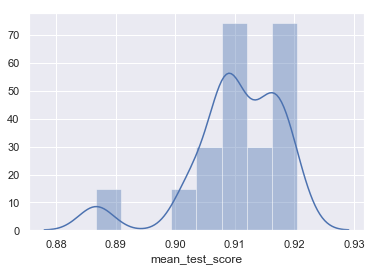

In [23]:
sns.distplot(df['mean_test_score'])

### Classification layers (fc_hidden layers)

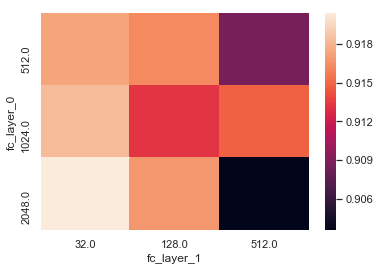

In [31]:
df_h = df.pivot_table(values='test_score', index='fc_layer_0', columns='fc_layer_1') # make a 2D array
sns.heatmap(df_h)

/Users/alexandre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


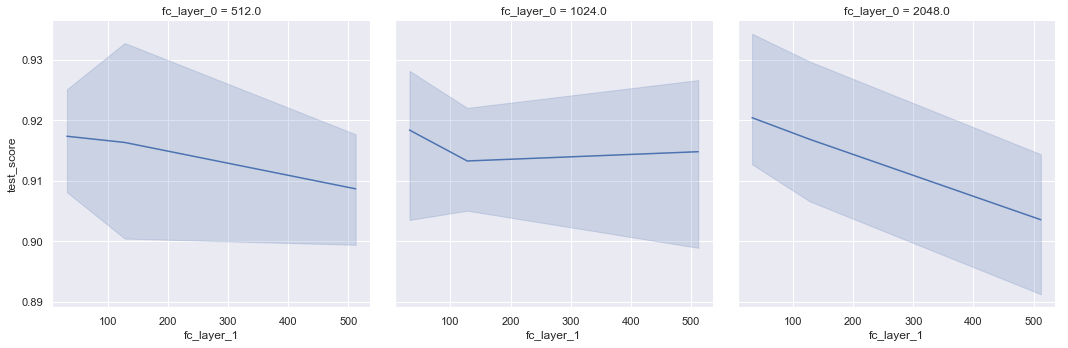

In [37]:
ax = sns.relplot(x='fc_layer_1', y='test_score', kind='line', col='fc_layer_0', data=df[df.nb_h_layers>1])
ax.set_xlabels = 'Size of the second fully-connected layer'

/Users/alexandre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


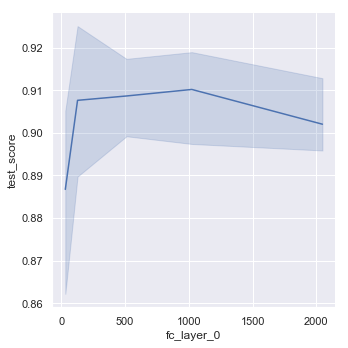

In [29]:
sns.relplot(x='fc_layer_0', y='test_score', kind='line', data=df[df.nb_h_layers==1])

### Preprocessing layers

/Users/alexandre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


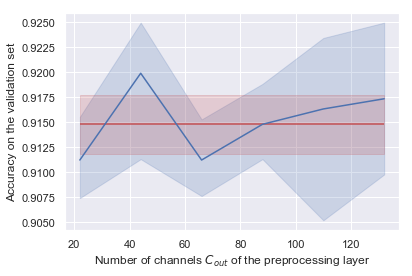

In [228]:
ax = sns.lineplot(x='layer_preprocessing_channels', y='test_score', data=df)

# add reference line and confidence interval
# mean test acc of the ref : 0.914795918367347
# std test acc of the ref : 0.0026198066515282156 (grid search 0328_2341, (22,1) architecture)
mean_acc = 0.914795918367347
ci = 1.96*0.0026198066515282156/3**(1/2) # 95% confidence interval
r = matplotlib.patches.Rectangle((22, mean_acc-ci), width=110, height=2*ci, alpha=0.2, color='r')
ax.add_artist(r)
ax.hlines(mean_acc, 22, 132, colors='r')

ax.set_ylabel('Accuracy on the validation set')
ax.set_xlabel('Number of channels $C_{out}$ of the preprocessing layer')

plt.savefig('/Users/alexandre/Desktop/S3R rapport/img/preprocessing.png', format='png')

### Convolution architecture : _groups_ parameter

How does the groups parameter influence the score ? for architectures with 1 layer, and $C_{out}=22$ or $66$

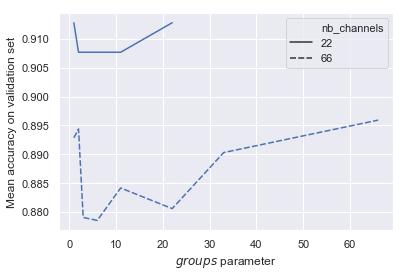

In [144]:
ax = sns.lineplot(x='layer_0_groups', y='mean_test_score', style='nb_channels', data=df[df.nb_layers==1])
ax.set_xlabel('$groups$ parameter')
ax.set_ylabel('Mean accuracy on validation set')
plt.savefig('/Users/alexandre/Desktop/S3R rapport/img/groups-param-nb-channels.eps', format='eps')

How does the groups parameter influence the score ? for architectures with 2 or 4 layers, and $C_{out}=96$

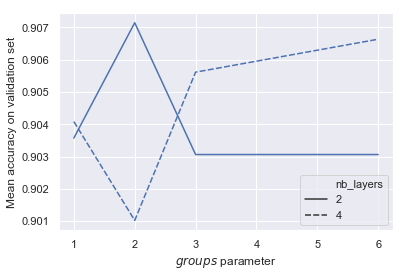

In [145]:
ax = sns.lineplot(x='layer_0_groups', y='mean_test_score', style='nb_layers', data=df[df.nb_layers>1])
ax.set_xlabel('$groups$ parameter')
ax.set_ylabel('Mean accuracy on validation set')
plt.savefig('/Users/alexandre/Desktop/S3R rapport/img/groups-param-nb-layers.eps', format='eps')

### Convolution architecture : nb and size of layers

Heatmap to see relations between the 2 parameters.
Use grid search id *0328_2341*

It seems that 
- generally, less layers make the networks learn better
- when there is only 1 layer, it seems important to have a small filter size

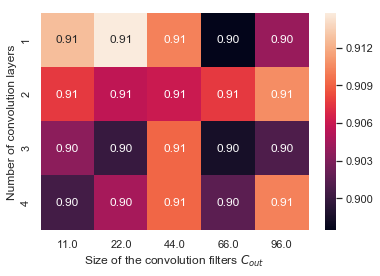

In [240]:
df_h = df.pivot_table(values='mean_test_score', index='nb_layers', columns='layer_0_channels') # assuming that all layers have the same nb of channels
ax = sns.heatmap(df_h, annot=True, fmt='0.2f')
ax.set(xlabel='Size of the convolution filters $C_{out}$', ylabel='Number of convolution layers')
plt.savefig('/Users/alexandre/Desktop/S3R rapport/img/heatmap-conv-layers-nb-size.eps', format='eps')

/Users/alexandre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


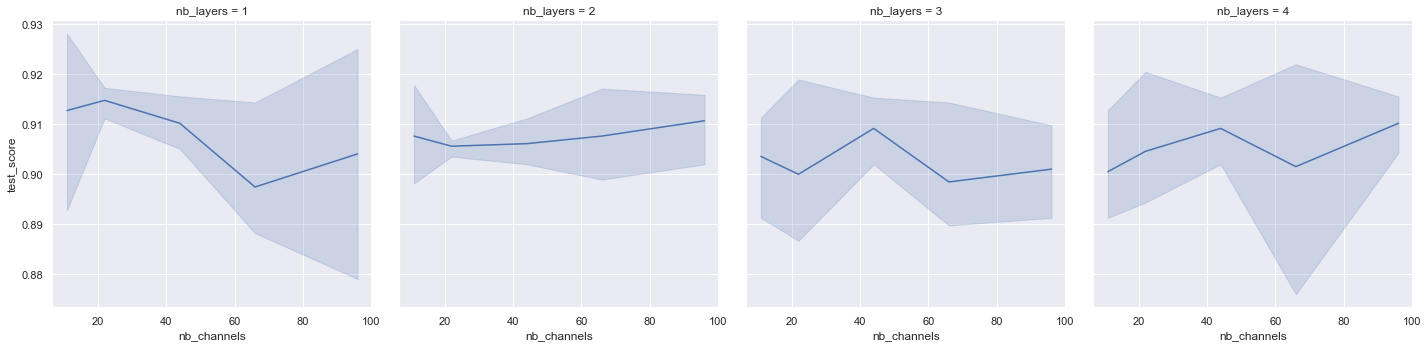

In [233]:
sns.relplot(x='nb_channels', y='test_score', col='nb_layers', kind='line', data=df)

/Users/alexandre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


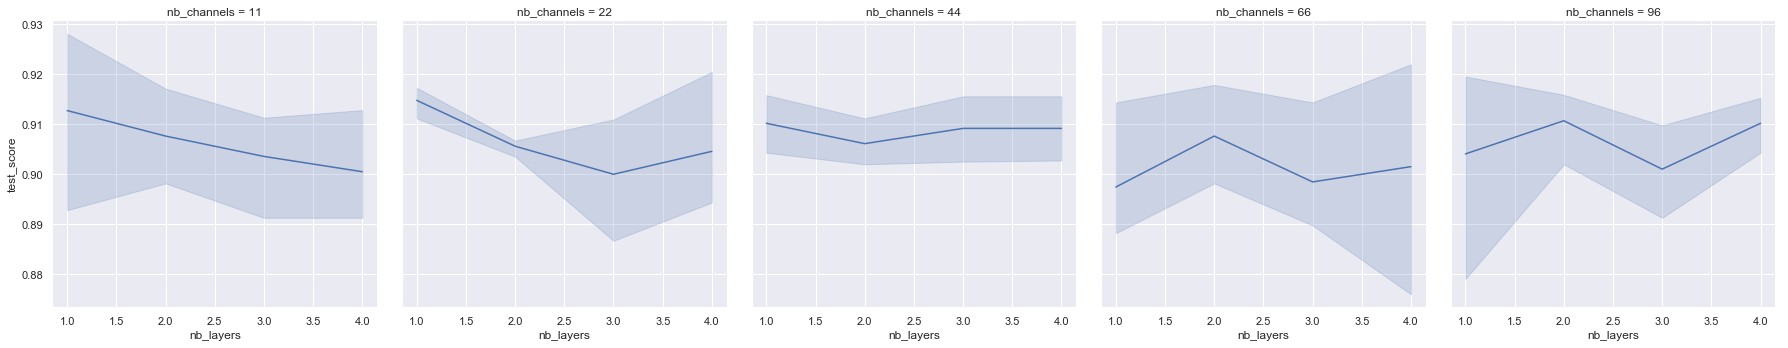

In [234]:
sns.relplot(x='nb_layers', y='test_score', col='nb_channels', kind='line', data=df)

/Users/alexandre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


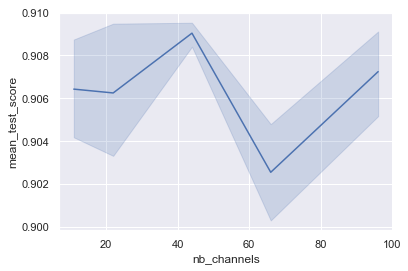

In [239]:
sns.lineplot(x='nb_channels', y='mean_test_score', data=df)#, hue='nb_layers')

For grid searches, see the relation between training score and test score, to eventually see overfitting.
It seems that 

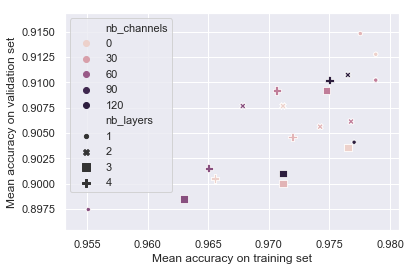

In [242]:
ax = sns.scatterplot(x='mean_train_score', y='mean_test_score', data=df, hue='nb_channels', size='nb_layers', style='nb_layers')
ax.set(xlabel='Mean accuracy on training set', ylabel='Mean accuracy on validation set')
plt.savefig('/Users/alexandre/Desktop/S3R rapport/img/scatter-conv-layers-nb-size.eps', format='eps')

# Comparison searches

### Accuracy results

In [ ]:
ax = sns.distplot(df['acc'], axlabel='Accuracy')
sns.distplot(df['f1_score'], axlabel='F1')

### Hyperparameters influence

First, the batch size
It seems that, with default configuration, optimal batch size is around 128.

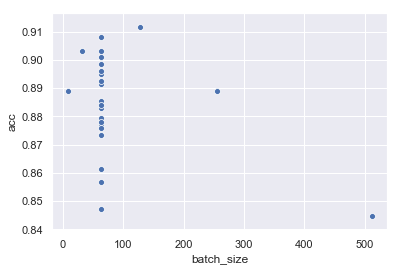

In [124]:
sns.scatterplot(x='batch_size', y='acc', data=df)

For the activation function, we need more data

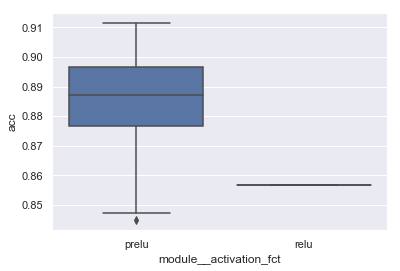

In [125]:
sns.boxplot(x='module__activation_fct', y='acc', data=df)

Look at the hidden layers

We have 2 fully-connected layers before the output, it goes like this :
fc_layer_0 -> fc_layer_1 -> nb_gestures

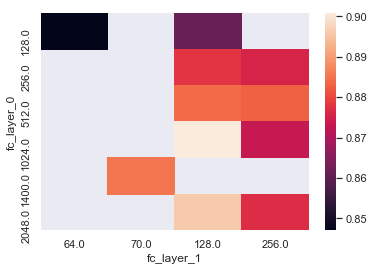

In [126]:
# select only the rows where fc_hidden_layers changes, and make it a 2D array
df_h = df.iloc[14:,:]
df_h = df_h.pivot_table(values='acc', index='fc_layer_0', columns='fc_layer_1')

sns.heatmap(df_h)

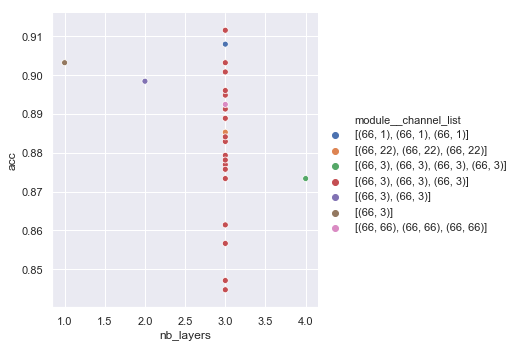

In [127]:
sns.relplot(x='nb_layers', y='acc', hue='module__channel_list', data=df)

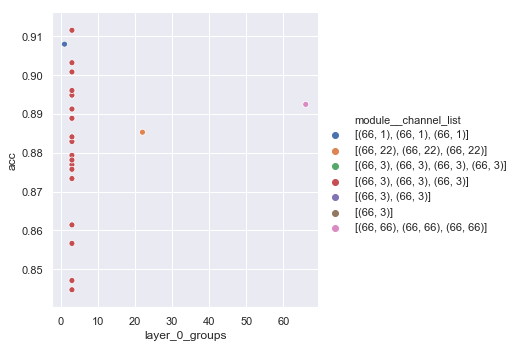

In [128]:
sns.relplot(x='layer_0_groups', y='acc', hue='module__channel_list', data=df[df.nb_layers==3])